In [1]:
import pandas as pd

EVAL_OUTPUT_DIR = '../outputs/eval'
SETTING = 'gemini-2.5-flash'
DATASET = 'visual_probe_hard'
TRIAL_ID = 0

eval_records = pd.read_json(f'{EVAL_OUTPUT_DIR}/{SETTING}/{DATASET}/trial_{TRIAL_ID}/eval_records.jsonl', lines=True)
eval_records.head()

question_id                                           image  \
0  visual_probe_hard_48  VisualProbe_Hard/data/visual_probe_hard_48.jpg   
1  visual_probe_hard_81  VisualProbe_Hard/data/visual_probe_hard_81.jpg   
2  visual_probe_hard_65  VisualProbe_Hard/data/visual_probe_hard_65.jpg   
3   visual_probe_hard_6   VisualProbe_Hard/data/visual_probe_hard_6.jpg   
4  visual_probe_hard_33  VisualProbe_Hard/data/visual_probe_hard_33.jpg   

                                            question answer  \
0  What is the English word to the left of the nu...    FOR   
1  What color are the shorts on the person in a b...  white   
2  What color is the body of the butterfly with b...  brown   
3                   What color is the text "PROUD" ?   blue   
4  What color is the hat worn by the child in the...  white   

            category  sample_index  \
0  visual_probe_hard             3   
1  visual_probe_hard            16   
2  visual_probe_hard             2   
3  visual_probe_hard             6   
4  visual_probe_hard            10   

                                         eval_result  
0  {'sample_index': 3, 'success': True, 'fail_rea...  
1  {'sample_index': 16, 'success': True, 'fail_re...  
2  {'sample_index': 2, 'success': True, 'fail_rea...  
3  {'sample_index': 6, 'success': True, 'fail_rea...  
4  {'sample_index': 10, 'success': True, 'fail_re...

In [2]:
import base64
from PIL import Image
from io import BytesIO

from IPython.display import Markdown, Pretty

def display_message(message, print_image_size=False):
    display(Markdown(f"**{message['role'].capitalize()}:**"))
    if isinstance(message['content'], str):
        display(Pretty(f"{message['content']}"))
        return
    assert isinstance(message['content'], list), f"Unexpected message content type: {type(message['content'])}"
    for content in message['content']:
        if content['type'] == 'text':
            display(Pretty(f"{content['text']}"))
        elif content['type'] in ('image', 'image_url'):
            if content['type'] == 'image_url':
                if not content['image_url']['url'].startswith('data:image'):
                    raise ValueError("Only supports base64 encoded image url")
                _, base64_data = content['image_url']['url'].split("base64,", 1)
                data = base64.b64decode(base64_data)
                image = Image.open(BytesIO(data))
            else:
                image = content['image']
            display(image)
            if print_image_size:
                display(Markdown(f"image size: {image.size}"))
        else:
            raise ValueError(f"Unsupported content type: {content['type']}")

def display_conversations(conversations, print_image_size=False):
    for conversation in conversations:
        agent_name = conversation.get('agent', 'unknown agent/model')
        display(Markdown(f"`>>> {agent_name} messages start`"))
        for message in conversation['messages']:
            display_message(message, print_image_size=print_image_size)
        display(Markdown(f"`<<< {agent_name} messages stop`"))

`>>> gemini-2.5-flash messages start`

**User:**

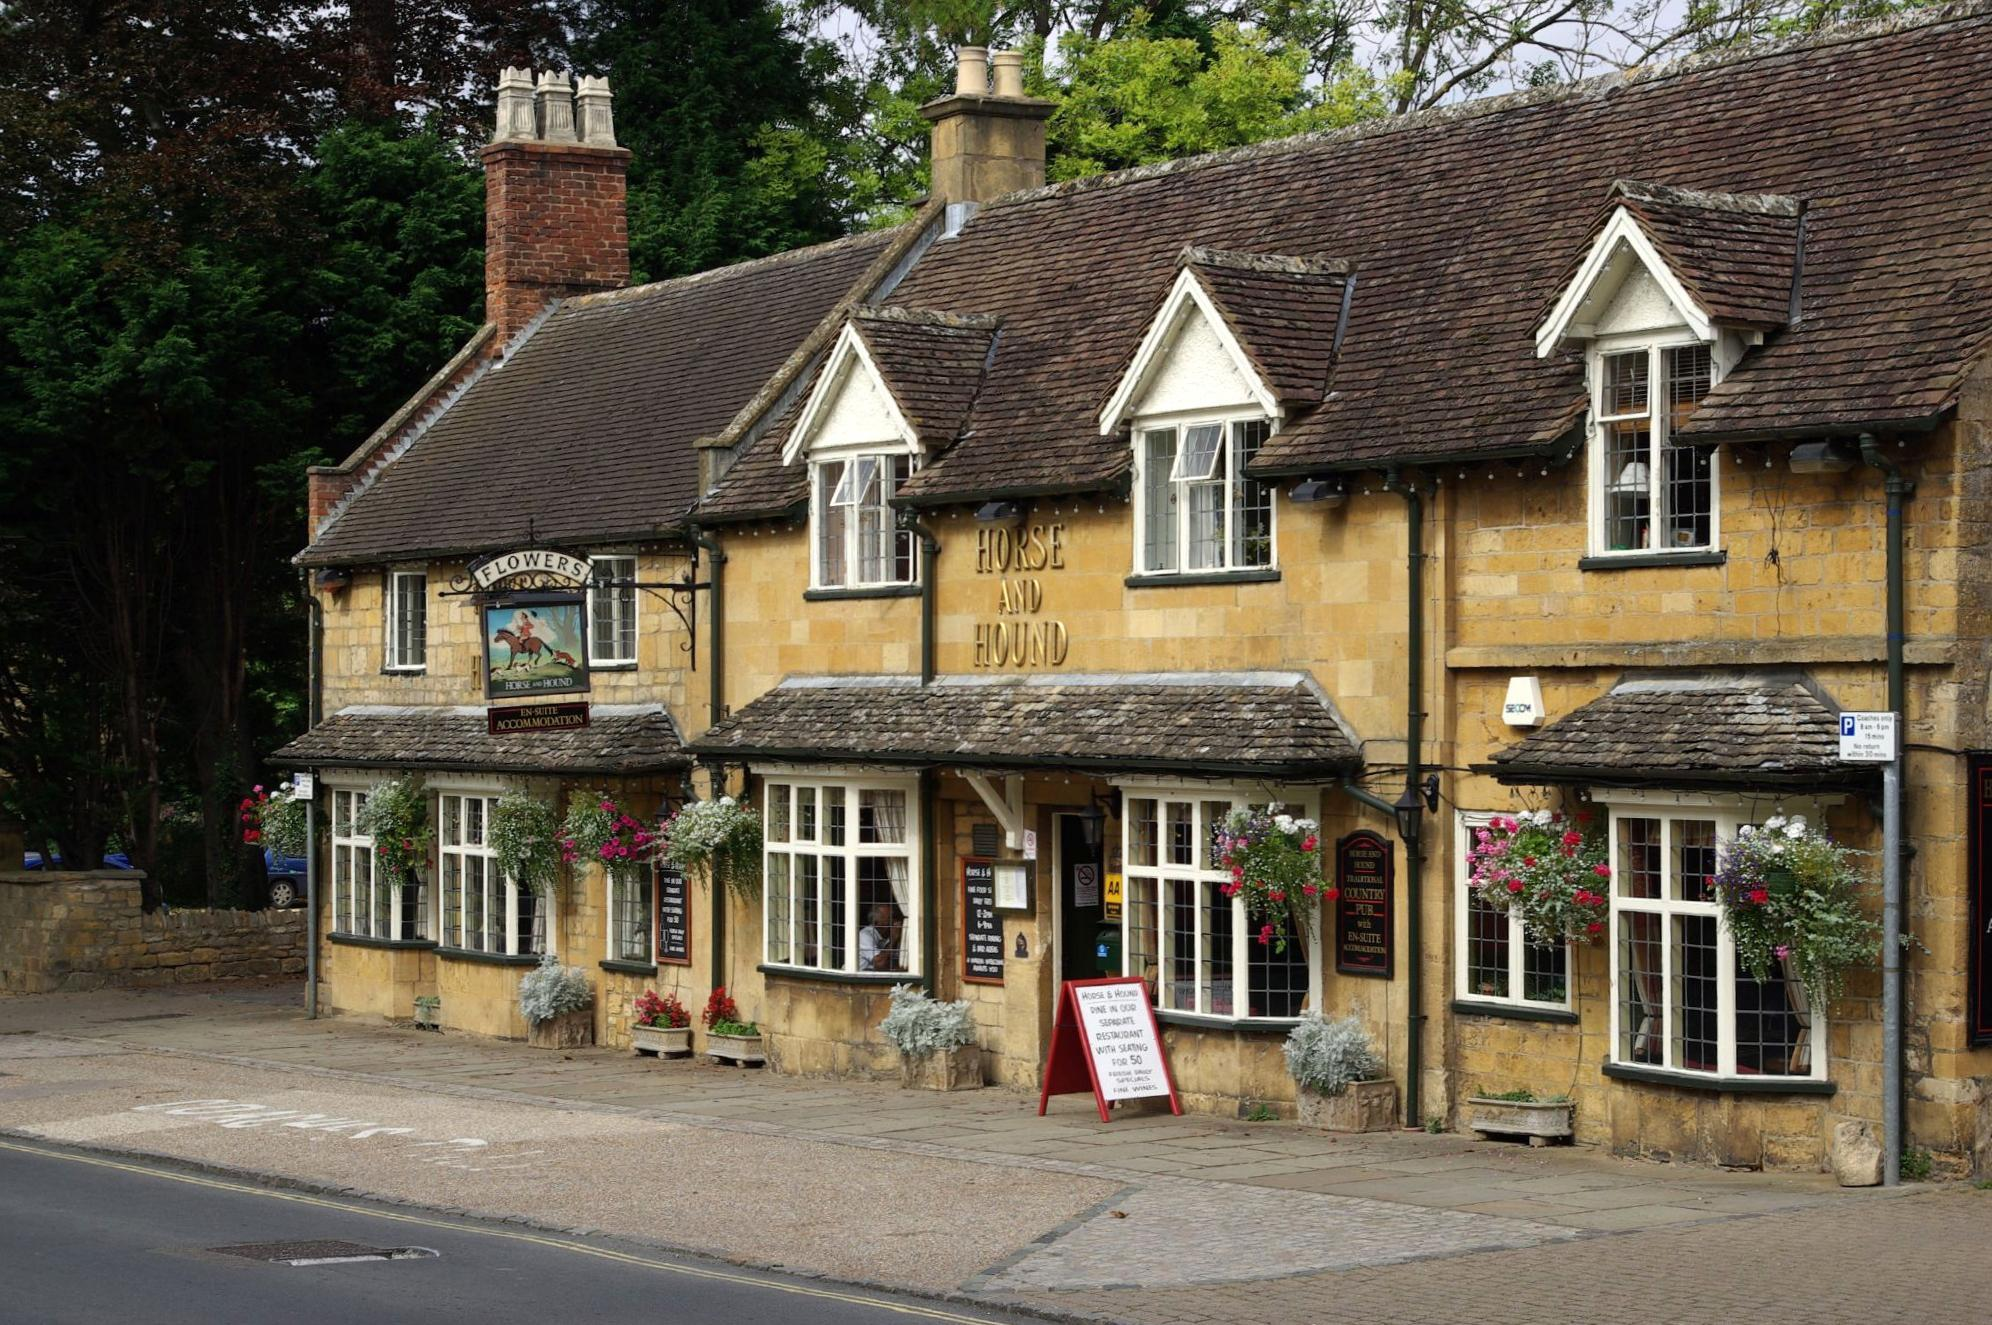

image size: (1992, 1325)

What is the English word to the left of the number 50?

**Assistant:**

Based on the OCR and the images, specifically the red A-frame sign, the word to the left of the number 50 is **FOR**.

`<<< gemini-2.5-flash messages stop`

Ground truth: FOR
Predicted: FOR
Is correct: True


In [3]:
example = eval_records.iloc[0]
eval_result = example['eval_result']
inference_result = eval_result['inference_result']

if not inference_result or not inference_result['success']:
    raise ValueError(f'Unable to display conversation due to failed inference (fail reason: {inference_result["fail_reason"]})')

conversations = inference_result['conversations']
conversations = example['eval_result']['inference_result']['conversations']
display_conversations(conversations, print_image_size=True)

if not example['eval_result']['success']:
    raise ValueError(f'Unable to display evaluation result due to {eval_result["fail_reason"]}')

print(f'Ground truth: {example["answer"]}')
print(f'Predicted: {eval_result["extracted_answer"]}')
print(f'Is correct: {eval_result["is_correct"]}')